In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
plt.style.use('ggplot')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
import pandas as pd
from scipy.stats import norm, multivariate_normal
import pymc as pm
from scipy.linalg import block_diag
import copy


In [2]:
dates = pd.date_range(start='1/1/2013', end='6/1/2014')
days = np.arange(0, len(dates), 1)
cov_1 = np.sin(2*np.pi/90 * days)
cov_2 = np.sin(2*np.pi/360 * days)
covs = np.vstack([cov_1, cov_2])

In [3]:
def make_block(A, B):
    mat = np.block([[A, np.zeros([A.shape[0], B.shape[1]])], [np.zeros([B.shape[0], A.shape[1]]), B]])
    return mat
    

In [4]:
# local linear trend
Z_1 = np.ones(len(dates)).reshape(1, -1)
T_1 = np.ones(1).reshape(-1, 1)
R_1 = np.eye(1).reshape(-1, 1)

# dynamic regression
Z_2 = covs
T_2 = np.eye(covs.shape[0])
R_2 = np.eye(covs.shape[0])

# combine arrays
Z = np.vstack([Z_1 , Z_2[0, :], Z_2[1, :]])
T = make_block(T_1, T_2)
R = make_block(R_1, R_2)
Q = np.diag([0.01] * 3)
R, T, Z

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.        ,  0.06975647,  0.1391731 , ..., -0.97029573,
         -0.98480775, -0.9945219 ],
        [ 0.        ,  0.01745241,  0.0348995 , ...,  0.43837115,
          0.42261826,  0.40673664]]))

In [5]:
alpha = np.zeros((3, len(dates)))
alpha[:, 0] = [10, 0, 0]
for i in range(len(dates)-1):
    alpha[:, i+1] = alpha[:, i]@T  + R@multivariate_normal(cov=Q).rvs()

In [6]:
y = (Z * alpha).sum(axis=0) + norm(0, .1).rvs(len(dates))
y_observed = copy.copy(y)

In [7]:
idx = int(np.where(dates ==  '2014-01-01')[0])
uplift = .2
y_observed[idx:] = y_observed[idx:] * (1 + uplift)

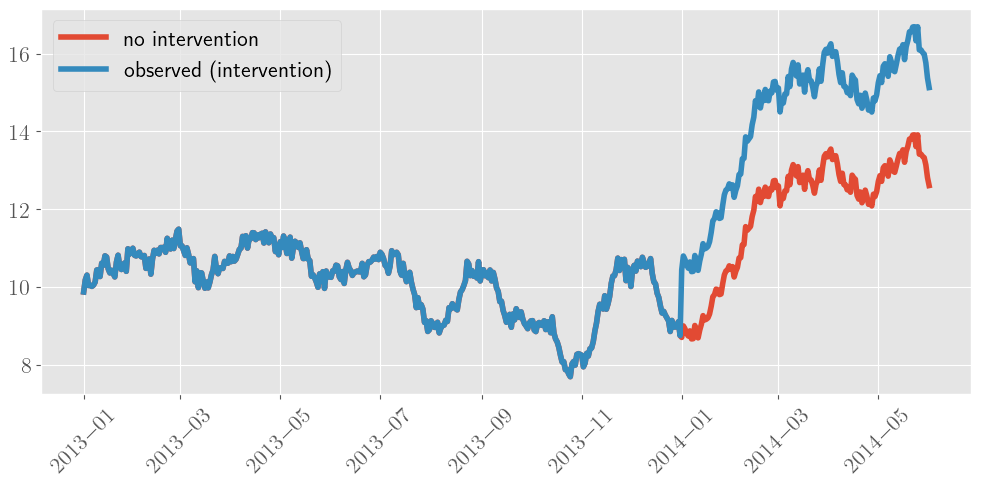

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(dates, y, label='no intervention')
plt.plot(dates, y_observed, label='observed (intervention)')
plt.xticks(rotation=45)
plt.legend();

In [9]:

cov

array([[  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  1.,   2.,   2., ...,   2.,   2.,   2.],
       [  1.,   2.,   3., ...,   3.,   3.,   3.],
       ...,
       [  1.,   2.,   3., ..., 514., 514., 514.],
       [  1.,   2.,   3., ..., 514., 515., 515.],
       [  1.,   2.,   3., ..., 514., 515., 516.]])

In [29]:
A = np.tri(len(y) - 1)
mat = A @A.T
with pm.Model() as model:
    
    mu_0 = pm.Normal('mu_0', 0, 10)
    beta_1_0 = pm.Normal('beta_1_0', 0, 10)
    beta_2_0 = pm.Normal('beta_2_0', 0, 10)
    q = pm.HalfCauchy('q', beta=1)
    cov = q * mat
    sigma_sq = pm.HalfCauchy('sigma_sq', beta=1)
    mus = pm.MvNormal('mus', mu=mu_0, cov=cov)
    beta_1 = pm.MvNormal('beta1', mu=beta_1_0 , cov=cov)
    beta_2 = pm.MvNormal('beta2', mu=beta_2_0, cov=cov)
    
    yt = mus*Z[0, :][1:] + (beta_1*Z[1, :][1:]) + (beta_2*Z[2, :][1:])
    like = pm.Normal('like', mu=yt, sigma=np.sqrt(sigma_sq), observed=y[1:])
    traces = pm.sample(return_inferencedata=None,  chains=1, draws=500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_0, beta_1_0, beta_2_0, q, sigma_sq, mus, beta1, beta2]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 170309 seconds.
/Users/juliette/opt/anaconda3/envs/statmod1/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [37]:
names = ['q', 'beta_1_0', 'beta_2_0', 'sigma_sq', 'mus', 'beta1', 'beta2']

In [43]:
results = dict(zip(names, [traces[n] for n in names]))
import pickle

with open('traces.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


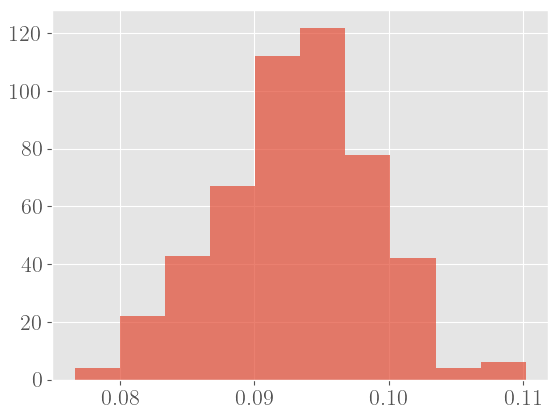

In [32]:
plt.hist(np.sqrt(traces['q']), alpha=.7);

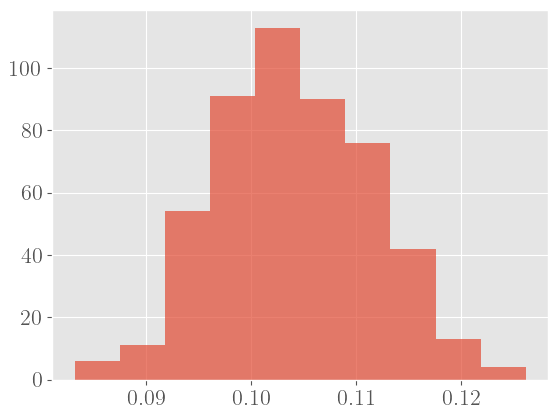

In [30]:
plt.hist(np.sqrt(traces['sigma_sq']), alpha=.7);

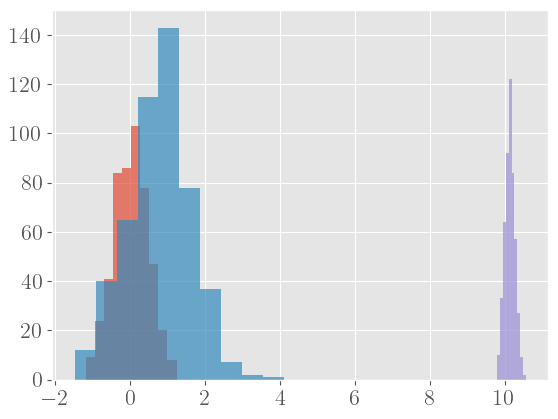

In [31]:
plt.hist(traces['beta_1_0'], alpha=.7);
plt.hist(traces['beta_2_0'], alpha=.7);
plt.hist(traces['mu_0'], alpha=.7);

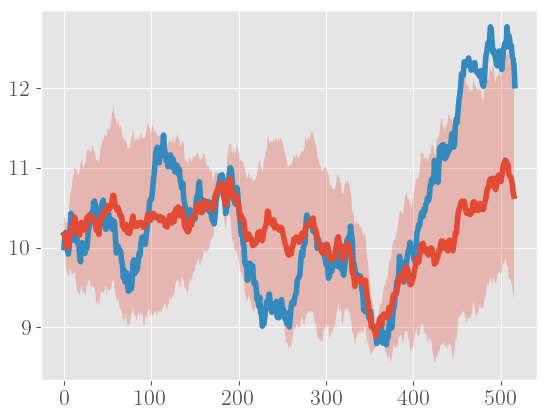

In [28]:
conf = np.quantile(traces['mus'], [.05/2, 1-.05/2], axis=0)
plt.fill_between(np.arange(0, 516, 1), *conf, alpha=.3);
plt.plot(traces['mus'].mean(axis=0), zorder=3);
plt.plot(alpha[0, :])

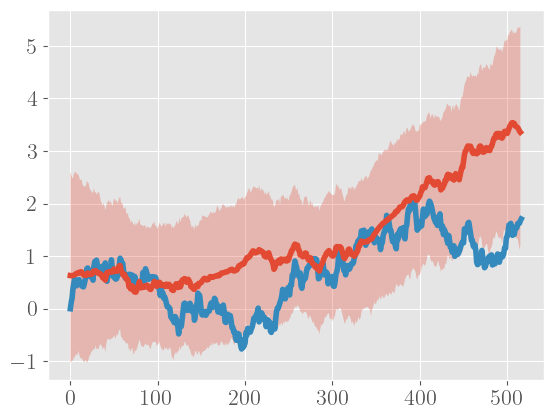

In [26]:
conf = np.quantile(traces['beta2'], [.05/2, 1-.05/2], axis=0)
plt.fill_between(np.arange(0, 516, 1), *conf, alpha=.3);
plt.plot(traces['beta2'].mean(axis=0), zorder=3);
plt.plot(alpha[2, :])

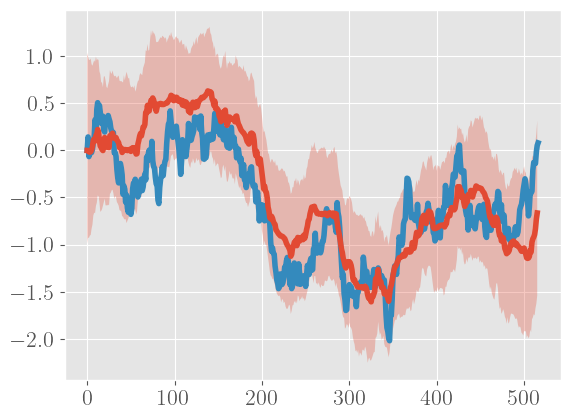

In [27]:
conf = np.quantile(traces['beta1'], [.05/2, 1-.05/2], axis=0)
plt.fill_between(np.arange(0, 516, 1), *conf, alpha=.3);
plt.plot(traces['beta1'].mean(axis=0), zorder=3);


plt.plot(alpha[1, :])

In [ ]:
plt.plot(traces['mus'].mean(axis=0));
plt.plot(alpha[0, :])

In [ ]:
conf = np.quantile(traces['mus'], [.05, 1-.05], axis=0)

In [ ]:
plt.plot(traces['mus'].mean(axis=0));
plt.plot(alpha[0, :])



In [ ]:
plt.plot(traces['mus'].mean(axis=0));
#plt.plot(conf[0])
#plt.plot(conf[1])

plt.plot(alpha[0, :]);

In [ ]:
mu = multivariate_normal(mean=[10] * (len(y) - 1), cov=cov)
plt.plot(mu.rvs(100).T)
plt.plot(alpha[0, :])

In [ ]:
alpha = np.zeros((3, len(dates)))
alpha[:, 0] = [10, 0, 0]
for _ in range(100):
    for i in range(len(dates)-1):
        alpha[:, i+1] = alpha[:, i]@T  + R@multivariate_normal(cov=Q).rvs()
    plt.plot(alpha[0, :])

In [ ]:
dim = 3
V10 = 10000*np.eye(dim)
x10 = np.zeros(dim)


KF(y[1:treatment],A=T,H=Z[1:treatment,, drop=F],R=sigmasq,Q,x10,V10)

def KF(y,A=T,H,R,Q,x10,V10):

In [ ]:
with pm.Model() as model:
    Q_terms = pm.Uniform('Q', 0, 5, shape=3)
    eps = pm.Uniform('eps', 0, 5)
    alpha = np.zeros((3, len(dates)))
    alpha[:, 0] = [10, 0, 0]
    for i in range(len(dates)-1):
        alpha[:, i+1] = alpha[:, i]@T 
    alpha = alpha + np.dot(R, Q_terms)
    
    pred = (Z * alpha).sum(axis=0) 
    like = pm.Normal('like', mu=pred, sigma=eps, observed=y)
    traces = pm.sample(return_inferencedata=None, target_accept=.99, chains=1)

In [ ]:
q = np.array([5, 5, 5])
np.dot(R, q)

In [ ]:
R * q

In [ ]:
for i in range(len(dates)-1):
        alpha[:, i+1] = alpha[:, i]@T  + R@np.sqrt(np.array([1, 1, 1]))

In [ ]:
alpha

In [ ]:
def draw_betas(betas, idx, sig):
    betas[idx+1] = norm(betas[idx], sig).rvs()
    return betas

def draw_mus(mus, idx, sig):
    mus[idx+1] = norm(mus[idx], sig).rvs()
    return mus
    
def make_betas_vector(n, sig=.01):
    betas = np.ones(n)
    for idx in range(n-1):
        betas = draw_betas(betas, idx, sig)
    return betas

def make_mus_vector(n, sig=.1):
    mus = np.zeros(n)
    for idx in range(n-1):
        mus = draw_mus(mus, idx, sig)
    return mus

In [ ]:

beta_1 = make_betas_vector(len(dates))
beta_2 = make_betas_vector(len(dates))
mus = make_mus_vector(len(dates))
eps = norm(0, .1).rvs(len(dates))
uplift = .2
data = beta_1*cov_1 + beta_2*cov_2 + mus + eps
plt.figure(figsize=(10, 5))
plt.plot(dates, data)


plt.xticks(rotation=45)
plt.plot(dates, data)
plt.plot(dates, cov_1)
plt.plot(dates, cov_2)

In [ ]:
with pm.Model() as model:
    sig_1 = np.sqrt(pm.InverseGamma('sig1', 0.5, 0.5))
    sig_2 = np.sqrt(pm.InverseGamma('sig2', 0.5, 0.5))                
    sig_mu = np.sqrt(pm.InverseGamma('sig_mu', 0.5, 0.5))
    betas_1 = make_betas_vector(idx, sig_1.eval())
    betas_2 = make_betas_vector(idx, sig_2.eval())
    mus =  make_mus_vector(idx, sig_mu.eval())
    eps = np.sqrt(pm.InverseGamma('sigma', 0.5, 0.5))
    like = pm.Normal('like', betas_1 * cov_1[:idx] + betas_2 * cov_2[:idx] + mus, eps, observed=data[:idx])
    traces = pm.sample(return_inferencedata=None, target_accept=.99, chains=1)


In [ ]:
betas_1

In [ ]:
traces['like']

In [ ]:
plt.hist(traces['sig1'
               ])

In [ ]:
betas_1_mean = traces['betas1'].mean(axis=0)
betas_2_mean = traces['betas2'].mean(axis=0)
mus_mean = traces['mus'].mean(axis=0)
betas_1_full = np.concatenate([betas_1_mean, np.zeros(len(dates)-idx)])
betas_2_full = np.concatenate([betas_2_mean, np.zeros(len(dates)-idx)])
mus_full = np.concatenate([mus_mean, np.zeros(len(dates)-idx)])

for idx in range(idx, len(n_pred)):
    betas_1_full[idx] = norm(betas_1_full[idx], )

In [ ]:
betas_1_full[idx]

In [ ]:
plt.hist(traces['mus'][:, 0]);
plt.hist(traces['mus'][:, 5]);